<a href="https://colab.research.google.com/github/wyxuan02/GenerativeAI_class2025/blob/main/AI02_DNN%E6%89%8B%E5%AF%AB%E8%BE%A8%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

課程範例：https://github.com/yenlung/AI-Demo/blob/master/%E3%80%90Demo02%E3%80%91%E9%81%B7%E7%A7%BB%E5%BC%8F%E5%AD%B8%E7%BF%92%E5%81%9A%E5%85%AB%E5%93%A5%E8%BE%A8%E8%AD%98%E5%99%A8.ipynb

#第二週作業 02/25
**# 打造自己的DNN(全連結)手寫辨識**


｜實作說明｜

1. 讀入套件、資料庫
2. 輸入及輸出格式設定
3. 建構神經網路 (四層)，並且嘗試不同參數組合 (如截圖所示)
4. 使用不同激活函數
5. 組裝 DNN
6. 訓練神經網路，嘗試不同的 batch_size 和 epoch 數值 (最終設定 batch_size=150, epochs=100)
7. 呈現出訓練過程的 accuracy 和 loss (如圖所示)
8. 結果測試，準確率達九成
9. 用 Gradio 來展示 (結果如截圖所示)

## 1. 讀入套件

In [ ]:
!pip install gradio

In [ ]:
%matplotlib inline

# 標準數據分析、畫圖套件
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# 神經網路方面
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD

# 互動設計用
from ipywidgets import interact_manual

# 神速打造 web app 的 Gradio
import gradio as gr

#2. 讀入 MNIST 數據庫

MNIST (Modified NIST)：0-9 的手寫數字圖庫。
(Training data: 60000 / Testing data: 10000)

URL: http://yann.lecun.com/exdb/mnist/

### 2.1 由 Keras 讀入 MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
print(f'訓練資料總筆數為 {len(x_train)} 筆資料')
print(f'測試資料總筆數為 {len(x_test)} 筆資料')

In [ ]:
x_train.shape   # (60000筆數據,28x28的矩陣)

In [ ]:
x_train[66] # 查看單筆數據

### 2.2 數據庫的內容 (補充數據顯示器)

In [ ]:
def show_xy(n=0):
    ax = plt.gca()
    X = x_train[n]
    plt.xticks([], [])
    plt.yticks([], [])
    plt.imshow(X, cmap = 'Greys')
    print(f'本資料 y 給定的答案為: {y_train[n]}')

In [ ]:
interact_manual(show_xy, n=(0,59999));

In [ ]:
def show_data(n = 100):
    X = x_train[n]
    print(X)

In [ ]:
interact_manual(show_data, n=(0,59999));

### 2.3 輸入格式整理

將原 28x28 reshape 成 784

In [ ]:
# Normalization
x_train = x_train.reshape(60000, 784)/255  # 把數字壓到0-1之間
x_test = x_test.reshape(10000, 784)/255

In [ ]:
x_train.shape

### 2.4 輸出格式整理

In [ ]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [ ]:
y_train[66]

## 3. 打造神經網路

### 3.1 決定神經網路架構、讀入相關套件

指定
* 基活函數
* 多少個隱藏層
* 每層多少個神經元

### 3.2 建構神經網路

`Sequential` : 神經網路

In [ ]:
# 設定神經網路第一層N1神經元,第二層N2,第三層N3,第四層N4,第四層N4

N1 = 256
N2 = 128
N3 = 256
N4 = 128  # 嘗試N1至N4皆=25時，訓練準確率僅有0.84
#N5 = 256  # 當N1=256,N2=128,N3=256,N4=128時，訓練準確率提升至0.86，嘗試加入N5提高準確率(準確率反而下降至0.74，所以移除N5)

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(N1, input_dim=784, activation='relu'))

In [ ]:
model.add(Dense(N2, activation='relu'))   # 因為是全連接層，所以input_dim=前一層的神經元數

In [ ]:
model.add(Dense(N3, activation='tanh'))   # 試用`tanh`激活函數

In [ ]:
model.add(Dense(N4, activation='relu'))

In [ ]:
#model.add(Dense(N5, activation='relu'))   # 加入N5準確率反而下降至0.74，所以移除N5

In [ ]:
model.add(Dense(10, activation='softmax'))  # 輸出為多類別所以使用'softmax'

### 3.3 組裝

選擇
* loss function : `mse`
* optimizer : SGD, adam...
* learning rate
* 其他 metrics : `accuracy`


In [ ]:
model.compile(loss='mse', optimizer=SGD(learning_rate=0.01), metrics=['accuracy'])

## 4. 檢視

### 4.1 summary

In [ ]:
model.summary()

## 5. 訓練神經網路


* `batch_size` : 一次要訓練幾筆資料
* `epochs` : 這 6 萬筆資料一共要訓練幾次

In [ ]:
# AI prompt: 紀錄每次的訓練結果

class TrainingHistoryCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.accuracy = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.accuracy.append(logs.get('accuracy'))

history_callback = TrainingHistoryCallback()

In [ ]:
model.fit(x_train, y_train, batch_size=150, epochs=100, callbacks=[history_callback])  # 嘗試epochs=30，準確率僅有七八成

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history_callback.losses, label='Loss')
plt.plot(history_callback.accuracy, label='Accuracy')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

## 6. 結果

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

In [ ]:
print(f"測試資料正確率 {acc*100:.2f}%")

In [ ]:
predict = np.argmax(model.predict(x_test), axis=-1)

In [ ]:
predict

將 `x_test` 784 維的向量 reshape 回 28x28 的矩陣才能當成圖形顯示出來!

In [ ]:
def test(測試編號):
    plt.imshow(x_test[測試編號].reshape(28,28), cmap='Greys')
    print('神經網路判斷為:', predict[測試編號])

In [ ]:
interact_manual(test, 測試編號=(0, 9999));

In [ ]:
score = model.evaluate(x_test, y_test)

In [ ]:
print('loss:', score[0])
print('正確率', score[1])

### 7. 用 Gradio 來展示

In [ ]:
def resize_image(inp):
    # 圖在 inp["layers"][0]
    image = np.array(inp["layers"][0], dtype=np.float32)
    image = image.astype(np.uint8)

    # 轉成 PIL 格式
    image_pil = Image.fromarray(image)

    # Alpha 通道設為白色, 再把圖從 RGBA 轉成 RGB
    background = Image.new("RGB", image_pil.size, (255, 255, 255))
    background.paste(image_pil, mask=image_pil.split()[3]) # 把圖片粘貼到白色背景上，使用透明通道作為遮罩
    image_pil = background

    # 轉換為灰階圖像
    image_gray = image_pil.convert("L")

    # 將灰階圖像縮放到 28x28, 轉回 numpy array
    img_array = np.array(image_gray.resize((28, 28), resample=Image.LANCZOS))

    # 配合 MNIST 數據集
    img_array = 255 - img_array

    # 拉平並縮放
    img_array = img_array.reshape(1, 784) / 255.0

    return img_array

In [ ]:
def recognize_digit(inp):
    img_array = resize_image(inp)
    prediction = model.predict(img_array).flatten()
    labels = list('0123456789')
    return {labels[i]: float(prediction[i]) for i in range(10)}

In [ ]:
iface = gr.Interface(
    fn=recognize_digit,
    inputs=gr.Sketchpad(),
    outputs=gr.Label(num_top_classes=3),
    title="MNIST 手寫辨識",
    description="請在畫板上繪製數字"
)

iface.launch(share=True, debug=True)

# 手寫辨識結果

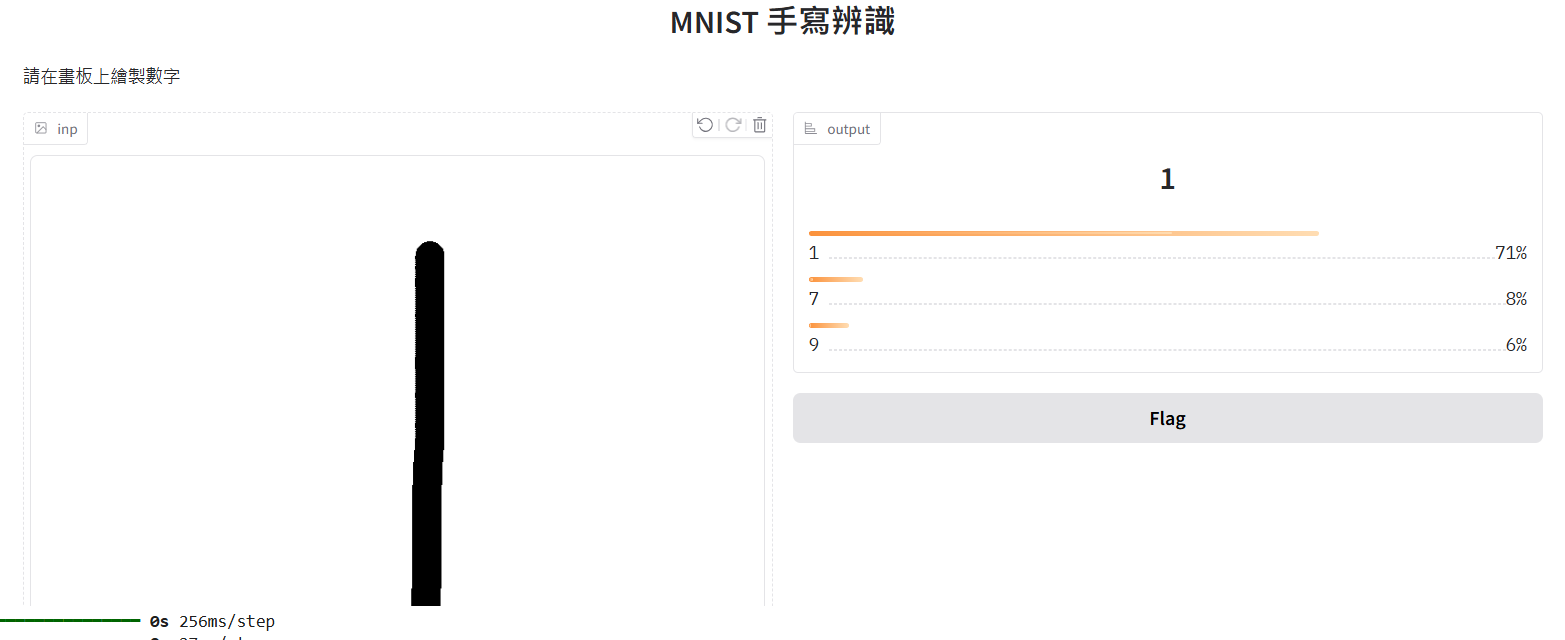

In [ ]:
!pip install nbformat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    for f in files:
        if "AI02_DNN手寫辨識.ipynb" in f:
            print(os.path.join(root, f))


In [18]:
import nbformat

# 設定 notebook 檔案路徑（換成你找到的完整路徑）
notebook_path = "/content/drive/MyDrive/Colab Notebooks/AI02_DNN手寫辨識.ipynb"

# 讀取 notebook
with open(notebook_path, "r", encoding="utf-8") as f:
    nb = nbformat.read(f, as_version=4)

# 移除所有輸出與 widgets metadata
for cell in nb.cells:
    if "outputs" in cell:
        cell["outputs"] = []
    if "execution_count" in cell:
        cell["execution_count"] = None

if "widgets" in nb.metadata:
    del nb.metadata["widgets"]

# 儲存回 notebook
with open(notebook_path, "w", encoding="utf-8") as f:
    nbformat.write(nb, f)

print("✅ 已移除 widgets metadata 與輸出，可以安全 push 到 GitHub！")


✅ 已移除 widgets metadata 與輸出，可以安全 push 到 GitHub！
